In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 4.4 MB/s eta 0:00:01


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm

In [3]:
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((384,384)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(384),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((384,384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

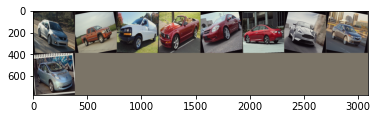

In [4]:
data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=9,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [5]:
model_ft = timm.create_model("vit_base_patch16_384", pretrained=True)
num_ftrs = model_ft.head.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024 #Small for Resnet, large for VGG
Num_class=196

class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    

model_ft.head= SpinalNetV1() 


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 5.5804 Acc: 0.0064
test Loss: 5.2059 Acc: 0.0165
Time from Start 17m 31s

Epoch 1/24
----------
train Loss: 5.4867 Acc: 0.0102
test Loss: 5.0578 Acc: 0.0280
Time from Start 32m 39s

Epoch 2/24
----------
train Loss: 5.2249 Acc: 0.0269
test Loss: 4.4000 Acc: 0.0856
Time from Start 47m 46s

Epoch 3/24
----------
train Loss: 3.8467 Acc: 0.1449
test Loss: 2.3988 Acc: 0.4218
Time from Start 62m 43s

Epoch 4/24
----------
train Loss: 2.1972 Acc: 0.4300
test Loss: 1.2656 Acc: 0.6545
Time from Start 77m 48s

Epoch 5/24
----------
train Loss: 1.3132 Acc: 0.6439
test Loss: 0.8200 Acc: 0.7656
Time from Start 93m 28s

Epoch 6/24
----------
train Loss: 0.8654 Acc: 0.7580
test Loss: 0.7255 Acc: 0.7911
Time from Start 109m 1s

Epoch 7/24
----------
train Loss: 0.4372 Acc: 0.8854
test Loss: 0.4098 Acc: 0.8809
Time from Start 124m 26s

Epoch 8/24
----------
train Loss: 0.3359 Acc: 0.9171
test Loss: 0.3828 Acc: 0.8889
Time from Start 140m 5s

Epoch 9/24
----------
train

In [8]:
!pip install disarray

In [9]:
#TEST
nb_classes = 196

test_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (test_inputs, test_classes) in enumerate(dataloaders['test']):
        test_inputs = test_inputs.to(device)
        test_classes = test_classes.to(device)
        test_outputs = model_ft(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        for t, p in zip(test_classes.view(-1), test_preds.view(-1)):
            test_confusion_matrix[t.long(), p.long()] += 1

print(test_confusion_matrix)

tensor([[42.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 40.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 30.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 39.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 42.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 39.]])


     |████████████████████████████████| 243 kB 4.0 MB/s eta 0:00:01


Text(0.5, 69.0, 'Predicted label')

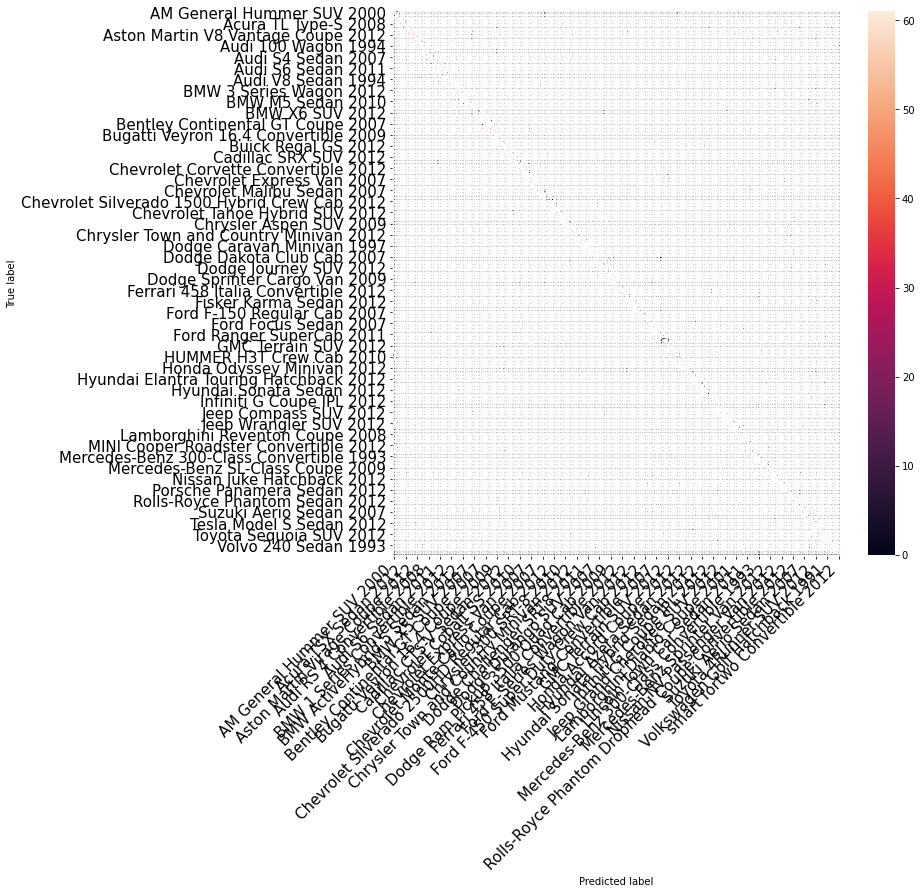

In [10]:
!pip install openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import openpyxl

plt.figure(figsize=(10,10))
class_names = list(image_datasets['test'].classes)
test_df_cm = pd.DataFrame(test_confusion_matrix, index=class_names, columns=class_names).astype(int)
test_heatmap = sns.heatmap(test_df_cm, annot=True, fmt="d")
test_df_cm.to_excel('BVS1_Vision Transformer_SpinalNet_test_confusion_matrix.xlsx')

test_heatmap.yaxis.set_ticklabels(test_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
test_heatmap.xaxis.set_ticklabels(test_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

test_recall = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 1)
test_precision = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 0)
print("Recall")
print(test_recall.mean())

print("\nPresisi")
print(test_precision.mean())

Recall
0.9072704017455556

Presisi
0.9102438602175122


In [12]:
import disarray
 
print('accuracy: {:3f}'.format(accuracy(test_confusion_matrix)))
print('precision: {:3f}'.format(test_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(test_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(test_df_cm.da.f1.mean()))

accuracy: 0.908345
precision: 0.910244
recall: 0.907270
f1: 0.907154
